In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev, BSpline
from scipy.optimize import curve_fit
import sys
sys.path.append('../')
from package_global_functions import *
from filesHandling_quenched import *
from percolationAnalysis import getMeanClusterSize_ir

latexFont(ticklabelssize=12,labelsize=14) # ticklabelssize=10, labelsize=12, legendsize=8

def linFunc(x, a, b):
    return a*x + b

def powerLaw(x,a,b):
    return a*x**b

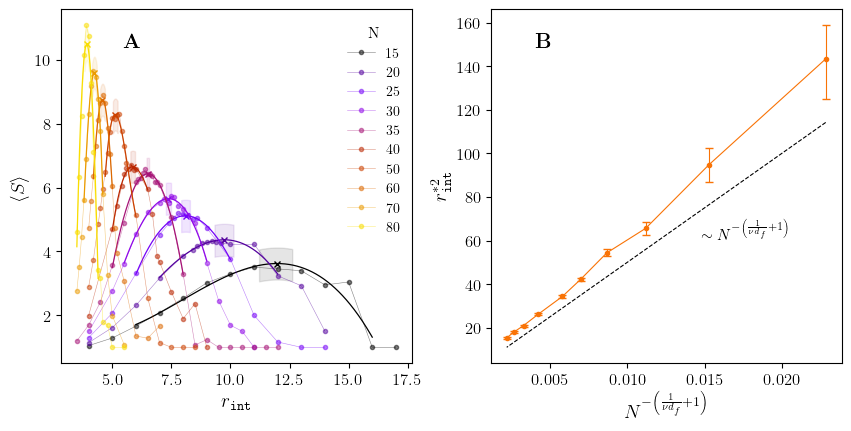

In [3]:
fig, ax = plt.subplots(1,2,figsize=(4.2*2,4.2), constrained_layout=True)

# LEFT: Mean cluster size analysis at different densities, in order to estimate the percolation interaction radius
ax[0].set(xlabel=r'$r_{\tt int}$', ylabel=r'$ \langle S \rangle $')
arena_r, exclusion_r, Ns = 20.0, 1.5, [15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
below_maxs = [5,6,4,6,6,6,6,4,4,4]
above_maxs = [5,5,6,5,8,3,4,4,4,4]
ss = [1,2,7,3,3,5,3,3,3,4]
eps, eps_shade = 0.15, 0.5
colors = plt.cm.gnuplot(np.linspace(0,0.95,len(Ns)))
percs_from_spline, ebars_from_spline = [], []
zipper = zip(Ns, ss, below_maxs, above_maxs, colors)
for z in zipper:
    N,s,below_max,above_max,color = z
    irs = availableIrs(N, arena_r, exclusion_r, push=False)
    dfmcs = getMeanClusterSize_ir(N, arena_r, exclusion_r, irs, push=False)
    ax[0].plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
    maxMCS = max(dfmcs['mcs'])
    i = dfmcs[dfmcs.mcs == maxMCS].index[0]
    irs_spline, mcs_spline = np.array(dfmcs.iloc[i-below_max:i+above_max+1].interac_r), np.array(dfmcs.iloc[i-below_max:i+above_max+1].mcs)
    tck_s = splrep(irs_spline, mcs_spline, s=s)
    irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
    mcs_interp = splev(irs_interp,tck_s)
    ax[0].plot(irs_interp, BSpline(*tck_s)(irs_interp), '-', color=color, lw=0.9)
    maxMCS = max(mcs_interp)
    index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
    perc_ir = irs_interp[index_maxMCS]
    percs_from_spline.append(perc_ir)
    # get the errorbars for percs_from_spline with the derivative criterion:
    if eps:
        hdata = (dfmcs.iloc[i+1].interac_r - dfmcs.iloc[i-1].interac_r)/2 # resolution around the max value of the meancluster size from simulated data
        h = irs_interp[1] - irs_interp[0]
        mcs_interp_der = (np.array(mcs_interp[2:]) - np.array(mcs_interp[:-2]))/(2*h)
        mcs_interp_der = np.insert(mcs_interp_der, 0, (mcs_interp[1] - mcs_interp[0])/h, axis=0)
        mcs_interp_der = np.append(mcs_interp_der, (mcs_interp[-1]-mcs_interp[-2])/h)
        irs_interp_der_eps = irs_interp[np.abs(mcs_interp_der) < eps]
        mcs_interp_der_eps = mcs_interp[np.abs(mcs_interp_der) < eps]
        min_ir, max_ir = irs_interp_der_eps[0], irs_interp_der_eps[-1]
        if (max_ir - min_ir) > hdata:
            ebars_from_spline.append((min_ir, max_ir))
            ax[0].fill_between(irs_interp_der_eps, mcs_interp_der_eps-eps_shade, mcs_interp_der_eps+eps_shade, color=color, alpha=0.1)
            ax[0].plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
        else:
            ebars_from_spline.append((perc_ir-hdata/2,perc_ir+hdata/2))
            irs_aux = irs_interp[(irs_interp >= perc_ir-hdata) & (irs_interp <= perc_ir+hdata)]
            mcs_aux = mcs_interp[(irs_interp >= perc_ir-hdata) & (irs_interp <= perc_ir+hdata)]
            ax[0].fill_between(irs_aux, mcs_aux-eps_shade, mcs_aux+eps_shade, color=color, alpha=0.1)
            ax[0].plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
ax[0].legend(title='N', loc=(0.8,0.35), fontsize=10, title_fontsize = 11, frameon=False)

ebars_from_spline = [(r-inf, sup-r) for r,(inf,sup) in zip(percs_from_spline, ebars_from_spline)]

# RIGHT: percolation radius scaling relation:
ax[1].set(xlabel=r'$N^{-\left(\frac{1}{\nu d_f}+1\right)}$', ylabel=r'$r_{\tt int}^{*2}$')
percs_sq = [r**2 for r in percs_from_spline]
ebars_sq = [(2*r*eb[0], 2*r*eb[1]) for r,eb in zip(percs_from_spline, ebars_from_spline)]
ebars_sq_reshape = np.array([[eb[0] for eb in ebars_sq], [eb[1] for eb in ebars_sq]])
nu, df = 4/3, 182/96
NwithExp = [N**(-1.0*(1/(nu*df)+1)) for N in Ns]
remove1520 = 0 # if 0 doesn't remove, if 2 yes
ax[1].errorbar(NwithExp[remove1520:], percs_sq[remove1520:], ebars_sq_reshape[:,remove1520:], marker='.', lw=0.8, elinewidth=0.8, capsize=3.0, color='xkcd:orange')

def ri_sq_scaling(N, rinf, Const):
    return rinf + Const * N**(-1.0*(1/(nu*df)+1))
teo = ri_sq_scaling(np.array(Ns), 0.0, 5000.0)
ax[1].plot(NwithExp[remove1520:], teo[remove1520:], ls='--', lw=0.8, color='xkcd:black')
ax[1].text(0.6, 0.35, r'$\sim N^{-\left(\frac{1}{\nu d_f}+1\right)}$', transform=ax[1].transAxes, fontsize= 11)

# ax[1].set(xlabel=r'$N^{-\frac{1}{2}(\frac{1}{\nu d_f}+1)}$', ylabel=r'$r_{\tt int}^{*}$')
# ebars_reshape = np.array([[eb[0] for eb in ebars_from_spline], [eb[1] for eb in ebars_from_spline]])
# NwithExp = [N**(-0.5*(1/(nu*df)+1)) for N in Ns]
# ax[1].errorbar(NwithExp, percs_from_spline, ebars_reshape, marker='.', lw=0.8, elinewidth=0.8, capsize=3.0, color='xkcd:orange')
# def ri_scaling(N, rinf, Const):
#     return rinf + Const * N**(-0.5*(1/(nu*df)+1))
# teo = ri_scaling(np.array(Ns), 0.0, 85.0)
# ax[1].plot(NwithExp, teo, ls='--', lw=0.8, color='xkcd:black')

fig.text(0.14, 0.9, r'$\textbf{A}$')
fig.text(0.63, 0.9, r'$\textbf{B}$')

fig.savefig('MCS_splines_perc_r_scaling_quenched.pdf')

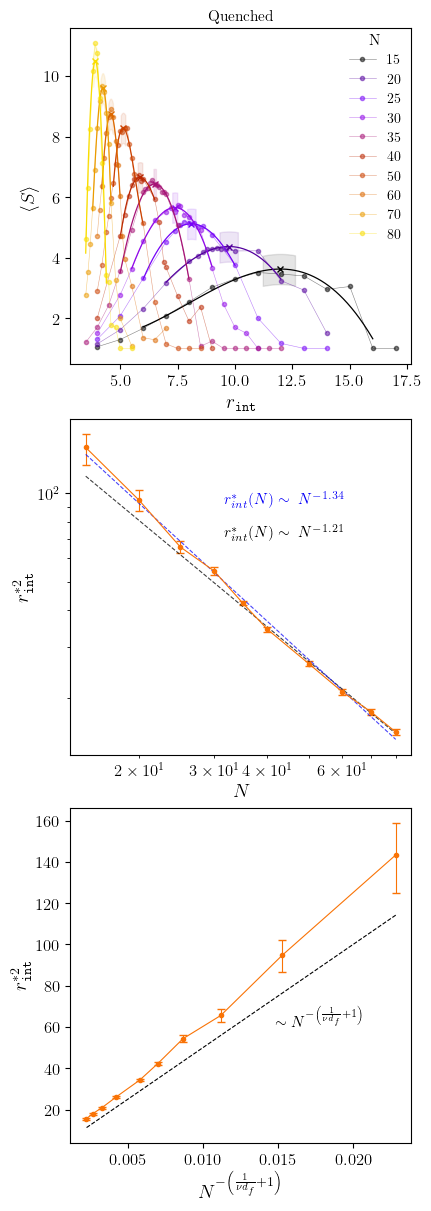

In [9]:
fig, ax = plt.subplots(3,1,figsize=(4.2,3*4.0), constrained_layout=True)

# TOP: Mean cluster size analysis at different densities, in order to estimate the percolation interaction radius
ax[0].set(xlabel=r'$r_{\tt int}$', ylabel=r'$ \langle S \rangle $')
arena_r, exclusion_r, Ns = 20.0, 1.5, [15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
below_maxs = [5,6,4,6,6,6,6,4,4,4]
above_maxs = [5,5,6,5,8,3,4,4,4,4]
ss = [1,2,7,3,3,5,3,3,3,4]
eps, eps_shade = 0.15, 0.5
colors = plt.cm.gnuplot(np.linspace(0,0.95,len(Ns)))
percs_from_spline, ebars_from_spline = [], []
zipper = zip(Ns, ss, below_maxs, above_maxs, colors)
for z in zipper:
    N,s,below_max,above_max,color = z
    irs = availableIrs(N, arena_r, exclusion_r, push=False)
    dfmcs = getMeanClusterSize_ir(N, arena_r, exclusion_r, irs, push=False)
    ax[0].plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
    maxMCS = max(dfmcs['mcs'])
    i = dfmcs[dfmcs.mcs == maxMCS].index[0]
    irs_spline, mcs_spline = np.array(dfmcs.iloc[i-below_max:i+above_max+1].interac_r), np.array(dfmcs.iloc[i-below_max:i+above_max+1].mcs)
    tck_s = splrep(irs_spline, mcs_spline, s=s)
    irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
    mcs_interp = splev(irs_interp,tck_s)
    ax[0].plot(irs_interp, BSpline(*tck_s)(irs_interp), '-', color=color, lw=0.9)
    maxMCS = max(mcs_interp)
    index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
    perc_ir = irs_interp[index_maxMCS]
    percs_from_spline.append(perc_ir)
    # get the errorbars for percs_from_spline with the derivative criterion:
    if eps:
        hdata = (dfmcs.iloc[i+1].interac_r - dfmcs.iloc[i-1].interac_r)/2 # resolution around the max value of the meancluster size from simulated data
        h = irs_interp[1] - irs_interp[0]
        mcs_interp_der = (np.array(mcs_interp[2:]) - np.array(mcs_interp[:-2]))/(2*h)
        mcs_interp_der = np.insert(mcs_interp_der, 0, (mcs_interp[1] - mcs_interp[0])/h, axis=0)
        mcs_interp_der = np.append(mcs_interp_der, (mcs_interp[-1]-mcs_interp[-2])/h)
        irs_interp_der_eps = irs_interp[np.abs(mcs_interp_der) < eps]
        mcs_interp_der_eps = mcs_interp[np.abs(mcs_interp_der) < eps]
        min_ir, max_ir = irs_interp_der_eps[0], irs_interp_der_eps[-1]
        if (max_ir - min_ir) > hdata:
            ebars_from_spline.append((min_ir, max_ir))
            ax[0].fill_between(irs_interp_der_eps, mcs_interp_der_eps-eps_shade, mcs_interp_der_eps+eps_shade, color=color, alpha=0.1)
            ax[0].plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
        else:
            ebars_from_spline.append((perc_ir-hdata/2,perc_ir+hdata/2))
            irs_aux = irs_interp[(irs_interp >= perc_ir-hdata) & (irs_interp <= perc_ir+hdata)]
            mcs_aux = mcs_interp[(irs_interp >= perc_ir-hdata) & (irs_interp <= perc_ir+hdata)]
            ax[0].fill_between(irs_aux, mcs_aux-eps_shade, mcs_aux+eps_shade, color=color, alpha=0.1)
            ax[0].plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
ax[0].legend(title='N', loc=(0.8,0.35), fontsize=10, title_fontsize = 11, frameon=False)

ebars_from_spline = [(r-inf, sup-r) for r,(inf,sup) in zip(percs_from_spline, ebars_from_spline)]



# MIDDLE: percolation radius scaling relation:
use_sigma=True
ax[1].set(xlabel=r'$N$', ylabel=r'$r_{\tt int}^{*2}$', xscale='log', yscale='log')
percs_sq = [r**2 for r in percs_from_spline]
ebars_sq = [(2*r*eb[0], 2*r*eb[1]) for r,eb in zip(percs_from_spline, ebars_from_spline)]
errors = [(eb[0]+eb[1])/2 for eb in ebars_sq]
ebars_sq_reshape = np.array([[eb[0] for eb in ebars_sq], [eb[1] for eb in ebars_sq]])
remove1520 = 0 # if 0 doesn't remove, if 2 yes
ax[1].errorbar(Ns[remove1520:], percs_sq[remove1520:], ebars_sq_reshape[:,remove1520:], marker='.', lw=0.8, elinewidth=0.8, capsize=3.0, color='xkcd:orange')
# if isinstance(errors, list) and use_sigma:
paramfit_w_err, covfit_w_err = curve_fit(linFunc, np.log(Ns), np.log(percs_sq), sigma=errors)
# else:
paramfit, covfit = curve_fit(linFunc, np.log(Ns), np.log(percs_sq))
# transform the parameters to those of the power law
const_w_err = np.exp(paramfit_w_err[1])
exponent_w_err = paramfit_w_err[0]
fit = powerLaw(np.array(Ns), const_w_err, exponent_w_err)
ax[1].plot(Ns, fit, ls='--', lw=0.8, color='xkcd:black', alpha=0.75)
# ax[1].text(0.45,0.65, fr'$r_{{int}}^*(N) \simeq {round(const_w_err,2)} \; N^{{{round(exponent_w_err,2)}}}$', transform=ax[1].transAxes, fontsize=11)
ax[1].text(0.45, 0.65, fr'$r_{{int}}^*(N) \sim \; N^{{{round(exponent_w_err,2)}}}$', transform=ax[1].transAxes, fontsize=11)
const = np.exp(paramfit[1])
exponent = paramfit[0]
fit = powerLaw(np.array(Ns), const, exponent)
ax[1].plot(Ns, fit, ls='--', lw=0.8, color='xkcd:strong blue', alpha=0.75)
# ax[1].text(0.45,0.65, fr'$r_{{int}}^*(N) \simeq {round(const_w_err,2)} \; N^{{{round(exponent_w_err,2)}}}$', transform=ax[1].transAxes, fontsize=11)
ax[1].text(0.45, 0.75, fr'$r_{{int}}^*(N) \sim \; N^{{{round(exponent,2)}}}$', transform=ax[1].transAxes, fontsize=11, color='xkcd:strong blue')



# BOTTOM: comparison with theoretical exponent
ax[2].set(xlabel=r'$N^{-\left(\frac{1}{\nu d_f}+1\right)}$', ylabel=r'$r_{\tt int}^{*2}$')
percs_sq = [r**2 for r in percs_from_spline]
ebars_sq = [(2*r*eb[0], 2*r*eb[1]) for r,eb in zip(percs_from_spline, ebars_from_spline)]
ebars_sq_reshape = np.array([[eb[0] for eb in ebars_sq], [eb[1] for eb in ebars_sq]])
nu, df = 4/3, 182/96
NwithExp = [N**(-1.0*(1/(nu*df)+1)) for N in Ns]
remove1520 = 0 # if 0 doesn't remove, if 2 yes
ax[2].errorbar(NwithExp[remove1520:], percs_sq[remove1520:], ebars_sq_reshape[:,remove1520:], marker='.', lw=0.8, elinewidth=0.8, capsize=3.0, color='xkcd:orange')

def ri_sq_scaling(N, rinf, Const):
    return rinf + Const * N**(-1.0*(1/(nu*df)+1))
teo = ri_sq_scaling(np.array(Ns), 0.0, 5000.0)
ax[2].plot(NwithExp[remove1520:], teo[remove1520:], ls='--', lw=0.8, color='xkcd:black')
ax[2].text(0.6, 0.35, r'$\sim N^{-\left(\frac{1}{\nu d_f}+1\right)}$', transform=ax[2].transAxes, fontsize= 11)

# fig.text(0.14, 0.9, r'$\textbf{A}$')
# fig.text(0.63, 0.9, r'$\textbf{B}$')

# fig.suptitle('Quenched', fontsize=11)
ax[0].set_title('Quenched', fontsize=11)

fig.savefig('sup_fig_MCS_splines_perc_r_N_relation_quenched.pdf')

In [3]:
const_w_err, exponent_w_err

(3002.5671598420568, -1.2066547209153078)

In [8]:
const_w_err*(np.sqrt(covfit_w_err[1][1])), np.sqrt(covfit_w_err[0][0])

(319.49301973020977, 0.02607629280231202)

In [6]:
const, exponent

(5065.728388180839, -1.336562264478351)

In [9]:
const*(np.sqrt(covfit[1][1])), np.sqrt(covfit[0][0])

(514.3108903182164, 0.027755406282599586)

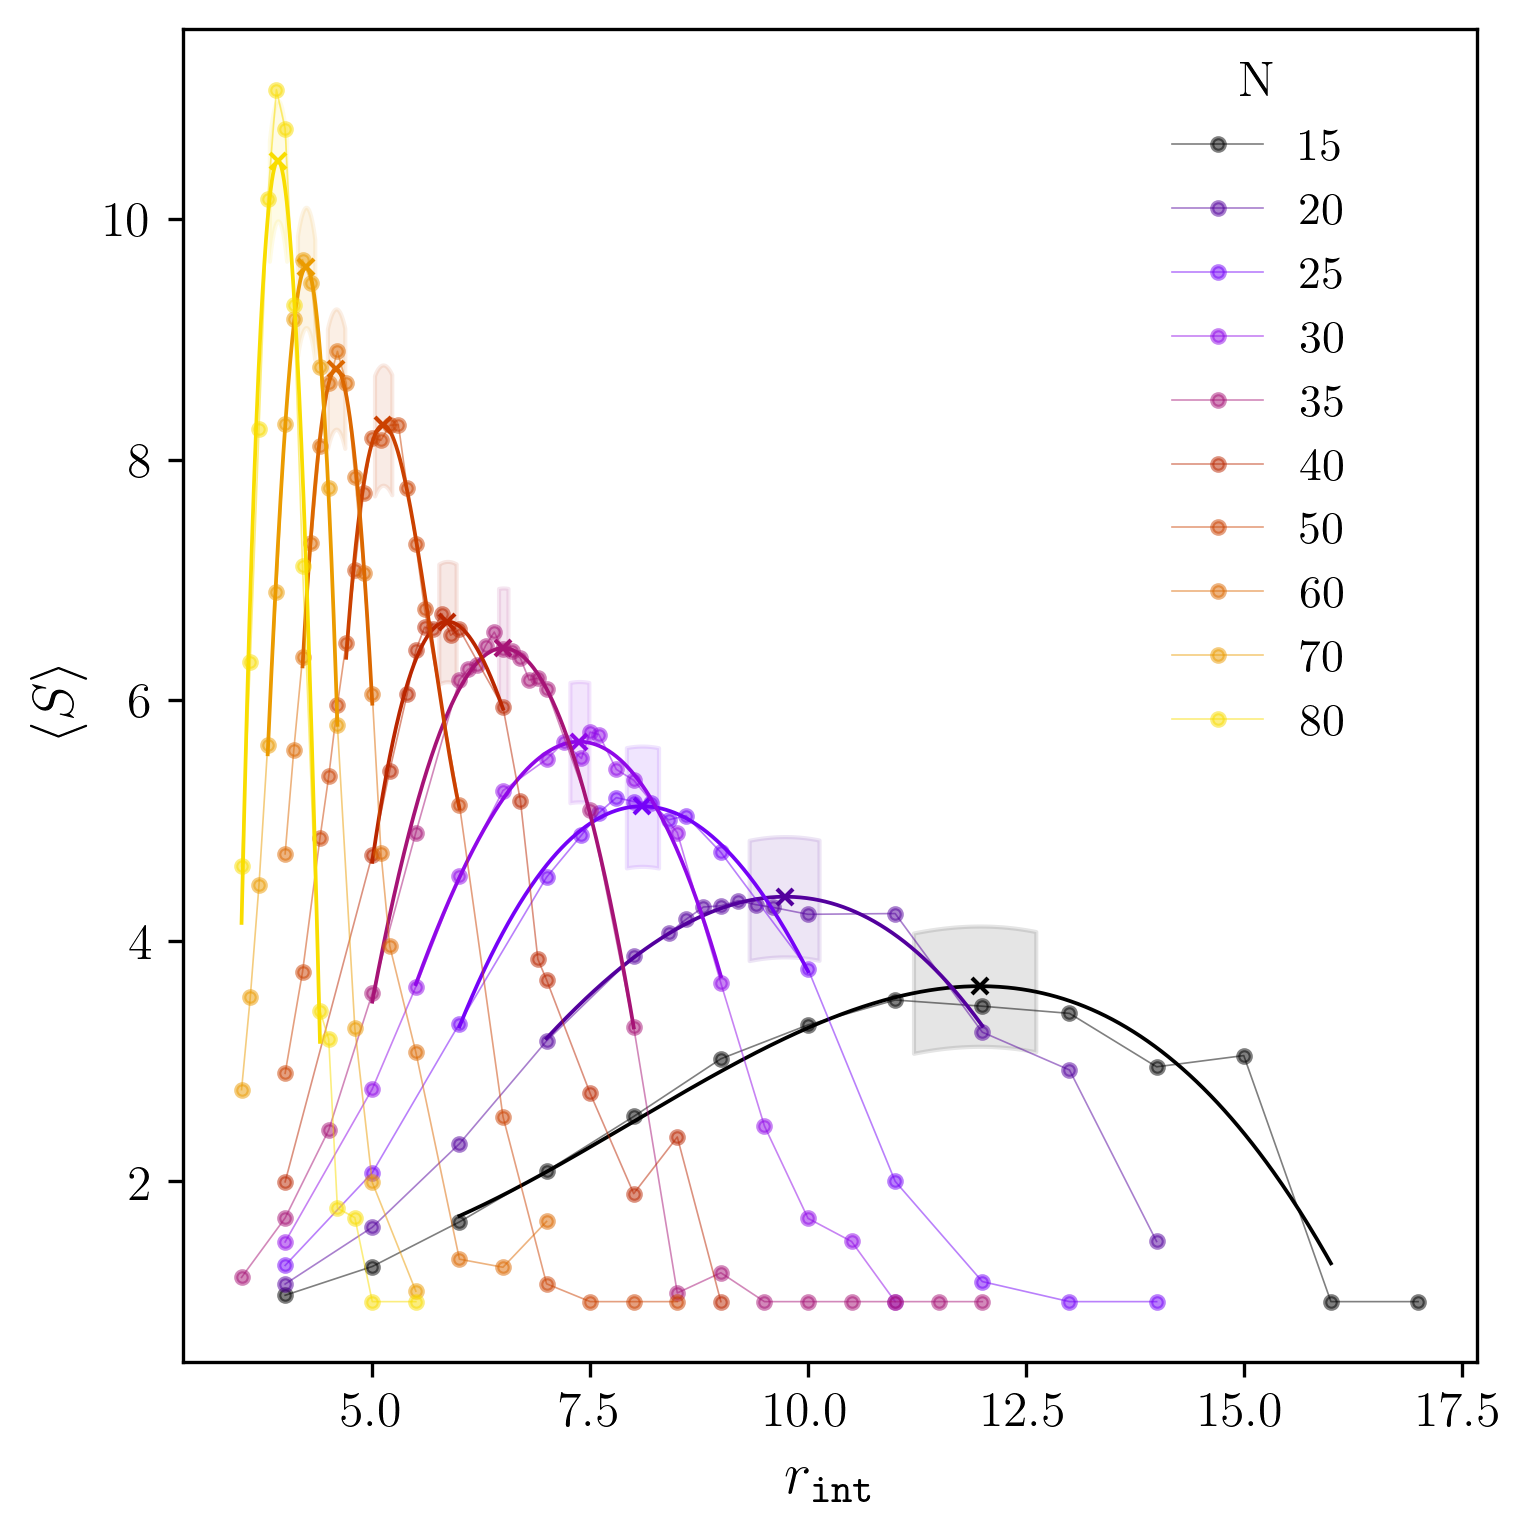

In [3]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True, dpi=300)
latexFont(ticklabelssize=14,labelsize=16)

# LEFT: Mean cluster size analysis at different densities, in order to estimate the percolation interaction radius
ax.set(xlabel=r'$r_{\tt int}$', ylabel=r'$ \langle S \rangle $')
arena_r, exclusion_r, Ns = 20.0, 1.5, [15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
below_maxs = [5,6,4,6,6,6,6,4,4,4]
above_maxs = [5,5,6,5,8,3,4,4,4,4]
ss = [1,2,7,3,3,5,3,3,3,4]
eps, eps_shade = 0.15, 0.5
colors = plt.cm.gnuplot(np.linspace(0,0.95,len(Ns)))
percs_from_spline, ebars_from_spline = [], []
zipper = zip(Ns, ss, below_maxs, above_maxs, colors)
for z in zipper:
    N,s,below_max,above_max,color = z
    irs = availableIrs(N, arena_r, exclusion_r, push=False)
    dfmcs = getMeanClusterSize_ir(N, arena_r, exclusion_r, irs, push=False)
    ax.plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
    maxMCS = max(dfmcs['mcs'])
    i = dfmcs[dfmcs.mcs == maxMCS].index[0]
    irs_spline, mcs_spline = np.array(dfmcs.iloc[i-below_max:i+above_max+1].interac_r), np.array(dfmcs.iloc[i-below_max:i+above_max+1].mcs)
    tck_s = splrep(irs_spline, mcs_spline, s=s)
    irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
    mcs_interp = splev(irs_interp,tck_s)
    ax.plot(irs_interp, BSpline(*tck_s)(irs_interp), '-', color=color, lw=0.9)
    maxMCS = max(mcs_interp)
    index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
    perc_ir = irs_interp[index_maxMCS]
    percs_from_spline.append(perc_ir)
    # get the errorbars for percs_from_spline with the derivative criterion:
    if eps:
        hdata = (dfmcs.iloc[i+1].interac_r - dfmcs.iloc[i-1].interac_r)/2 # resolution around the max value of the meancluster size from simulated data
        h = irs_interp[1] - irs_interp[0]
        mcs_interp_der = (np.array(mcs_interp[2:]) - np.array(mcs_interp[:-2]))/(2*h)
        mcs_interp_der = np.insert(mcs_interp_der, 0, (mcs_interp[1] - mcs_interp[0])/h, axis=0)
        mcs_interp_der = np.append(mcs_interp_der, (mcs_interp[-1]-mcs_interp[-2])/h)
        irs_interp_der_eps = irs_interp[np.abs(mcs_interp_der) < eps]
        mcs_interp_der_eps = mcs_interp[np.abs(mcs_interp_der) < eps]
        min_ir, max_ir = irs_interp_der_eps[0], irs_interp_der_eps[-1]
        if (max_ir - min_ir) > hdata:
            ebars_from_spline.append((min_ir, max_ir))
            ax.fill_between(irs_interp_der_eps, mcs_interp_der_eps-eps_shade, mcs_interp_der_eps+eps_shade, color=color, alpha=0.1)
            ax.plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
        else:
            ebars_from_spline.append((perc_ir-hdata/2,perc_ir+hdata/2))
            irs_aux = irs_interp[(irs_interp >= perc_ir-hdata) & (irs_interp <= perc_ir+hdata)]
            mcs_aux = mcs_interp[(irs_interp >= perc_ir-hdata) & (irs_interp <= perc_ir+hdata)]
            ax.fill_between(irs_aux, mcs_aux-eps_shade, mcs_aux+eps_shade, color=color, alpha=0.1)
            ax.plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
ax.legend(title='N', loc=(0.75,0.45), fontsize=11, title_fontsize = 12, frameon=False)
fig.savefig('meanCluserSize_dif_dens_for_poster.png')